<a href="https://colab.research.google.com/github/ethanquinn5/TermProject_Team10/blob/main/Final_Jack_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install google-cloud-bigquery pandas-gbq -q


In [3]:
from google.colab import auth
auth.authenticate_user()


In [4]:
from google.cloud import bigquery

project_id = "mgmt-467-94721"
client = bigquery.Client(project=project_id)

query = """
    SELECT *
    FROM `mgmt-467-94721.hotel_bookings.Hotel_Data`
"""

df = client.query(query).to_dataframe()

df.head(), df.shape


(          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
 0  Resort Hotel            0        342               2015               July   
 1  Resort Hotel            0        737               2015               July   
 2  Resort Hotel            0          7               2015               July   
 3  Resort Hotel            0         13               2015               July   
 4  Resort Hotel            0         14               2015               July   
 
    arrival_date_week_number  arrival_date_day_of_month  \
 0                        27                          1   
 1                        27                          1   
 2                        27                          1   
 3                        27                          1   
 4                        27                          1   
 
    stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
 0                        0                     0       2  ...    No D

In [8]:
import pandas as pd

# df is your raw table from BigQuery
# df = client.query("SELECT * FROM `mgmt-467-94721.hotel_bookings.Hotel_Data`").to_dataframe()

# 0. Filter to only Portugal bookings
df = df[df["country"] == "PRT"].copy()

# 1. Map month names → month numbers
month_map = {
"January": 1, "February": 2, "March": 3, "April": 4,
"May": 5, "June": 6, "July": 7, "August": 8,
"September": 9, "October": 10, "November": 11, "December": 12
}
df["arrival_month_num"] = df["arrival_date_month"].map(month_map)

# 2. Build a proper arrival_date column
df["arrival_date"] = pd.to_datetime({
"year": df["arrival_date_year"],
"month": df["arrival_month_num"],
"day": df["arrival_date_day_of_month"]
})

# 3. Parse reservation_status_date
df["reservation_status_date"] = pd.to_datetime(df["reservation_status_date"])

# 4. Derived feature: total number of guests
df["children"] = df["children"].fillna(0)
df["total_guests"] = df["adults"] + df["children"] + df["babies"]

# 5. Data-quality filters (use adr before we drop it)
df_curated = df[(df["total_guests"] > 0) & (df["adr"] >= 0)].copy()

# 6. Drop helper and unwanted columns
cols_to_drop = ["arrival_month_num", "company", "agent", "adr", "meal"]
df_curated.drop(columns=cols_to_drop, inplace=True, errors="ignore")

df_curated.head(), df_curated.shape


(          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
 0  Resort Hotel            0        342               2015               July   
 1  Resort Hotel            0        737               2015               July   
 6  Resort Hotel            0          0               2015               July   
 7  Resort Hotel            0          9               2015               July   
 8  Resort Hotel            1         85               2015               July   
 
    arrival_date_week_number  arrival_date_day_of_month  \
 0                        27                          1   
 1                        27                          1   
 6                        27                          1   
 7                        27                          1   
 8                        27                          1   
 
    stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
 0                        0                     0       2  ...   
 1                

Create Curated Table

In [10]:
import pandas_gbq

dataset_id = "hotel_bookings"
table_id = "hotel_bookings_curated"
full_table_id = f"{project_id}.{dataset_id}.{table_id}"

pandas_gbq.to_gbq(
    df_curated,
    full_table_id,
    project_id=project_id,
    if_exists="replace"  # or "fail" if you don't want to overwrite
)


100%|██████████| 1/1 [00:00<00:00, 9709.04it/s]


In [12]:
query = """
SELECT *
FROM `mgmt-467-94721.hotel_bookings.hotel_bookings_curated`
LIMIT 10
"""

df = client.query(query).to_dataframe()
df.head()



,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,total_guests
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,3,No Deposit,0,Transient,0,0,Check-Out,2015-07-01,2015-07-01,2
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,4,No Deposit,0,Transient,0,0,Check-Out,2015-07-01,2015-07-01,2
2,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,0,No Deposit,0,Transient,0,0,Check-Out,2015-07-03,2015-07-01,2
3,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,0,No Deposit,0,Transient,0,1,Check-Out,2015-07-03,2015-07-01,2
4,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,0,No Deposit,0,Transient,0,1,Canceled,2015-05-06,2015-07-01,2


In [13]:
query = """
SELECT COUNT(*) AS n_rows
FROM `mgmt-467-94721.hotel_bookings.hotel_bookings_curated`
"""
client.query(query).to_dataframe()


,n_rows
0,48479


In [14]:
query = """
CREATE OR REPLACE TABLE `mgmt-467-94721.hotel_bookings.hotel_bookings_curated` AS
SELECT
  *,
  CASE
    WHEN hotel = 'City Hotel' THEN 'Lisbon'
    WHEN hotel = 'Resort Hotel' THEN 'Algarve'
    ELSE 'Unknown'
  END AS booking_city
FROM `mgmt-467-94721.hotel_bookings.hotel_bookings_curated`;
"""
client.query(query).result()

print("Updated curated table with booking_city mapping.")


Updated curated table with booking_city mapping.


Create Streaming Table

In [15]:
query = """
CREATE TABLE IF NOT EXISTS `mgmt-467-94721.hotel_bookings.streaming_weather` (
  hotel_type STRING,
  timestamp_utc TIMESTAMP,
  temp_c FLOAT64,
  precip_mm FLOAT64,
  windspeed FLOAT64,
  weather_code INT64,
  ingestion_ts TIMESTAMP
);
"""
client.query(query).result()

print("Created streaming_weather table.")


Created streaming_weather table.


Create Training Data

In [21]:
from google.cloud import bigquery
client = bigquery.Client(project="mgmt-467-94721")

query = """
CREATE OR REPLACE TABLE `mgmt-467-94721.hotel_bookings.training_data` AS
WITH latest_weather AS (
  SELECT
    hotel_type,
    temp_c,
    windspeed,
    weather_code,
    timestamp_utc
  FROM `mgmt-467-94721.hotel_bookings.streaming_weather`
  QUALIFY ROW_NUMBER() OVER (
    PARTITION BY hotel_type
    ORDER BY timestamp_utc DESC
  ) = 1
)
SELECT
  b.*,
  w.temp_c,
  w.windspeed,
  w.weather_code,
  b.is_canceled AS label
FROM `mgmt-467-94721.hotel_bookings.hotel_bookings_curated` b
LEFT JOIN latest_weather w
  ON b.hotel = w.hotel_type;
"""

client.query(query).result()

print("✅ training_data table rebuilt with weather features.")


✅ training_data table rebuilt with weather features.


In [22]:
query = """
SELECT hotel, booking_city, temp_c, windspeed, weather_code, label
FROM `mgmt-467-94721.hotel_bookings.training_data`
LIMIT 10
"""
client.query(query).to_dataframe()


,hotel,booking_city,temp_c,windspeed,weather_code,label
0,City Hotel,Lisbon,12.2,11.8,61,1
1,City Hotel,Lisbon,12.2,11.8,61,1
2,City Hotel,Lisbon,12.2,11.8,61,1
3,City Hotel,Lisbon,12.2,11.8,61,1
4,City Hotel,Lisbon,12.2,11.8,61,1
5,City Hotel,Lisbon,12.2,11.8,61,1
6,City Hotel,Lisbon,12.2,11.8,61,1
7,City Hotel,Lisbon,12.2,11.8,61,1
8,City Hotel,Lisbon,12.2,11.8,61,1
9,City Hotel,Lisbon,12.2,11.8,61,1


Create Model for Cancelations With Streaming Data

In [23]:
query = """
CREATE OR REPLACE MODEL `mgmt-467-94721.hotel_bookings.cancel_model_with_weather`
OPTIONS(
  model_type = 'logistic_reg',
  input_label_cols = ['label']
) AS
SELECT
  hotel,
  booking_city,
  lead_time,
  arrival_date_year,
  arrival_date_week_number,
  stays_in_weekend_nights,
  stays_in_week_nights,
  total_guests,
  deposit_type,
  customer_type,
  total_of_special_requests,
  temp_c,
  windspeed,
  weather_code,
  label
FROM `mgmt-467-94721.hotel_bookings.training_data`;
"""

client.query(query).result()
print("✅ cancel_model_with_weather trained successfully.")


✅ cancel_model_with_weather trained successfully.


In [24]:
query = """
SELECT *
FROM ML.EVALUATE(MODEL `mgmt-467-94721.hotel_bookings.cancel_model_with_weather`);
"""
df_eval_weather = client.query(query).to_dataframe()
df_eval_weather


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.856267,0.746524,0.783473,0.797638,0.419335,0.878607


Create Model for Cancellations From Hotel Data Only

In [25]:
from google.cloud import bigquery
client = bigquery.Client(project="mgmt-467-94721")

query = """
CREATE OR REPLACE MODEL `mgmt-467-94721.hotel_bookings.cancel_model`
OPTIONS(
  model_type = 'logistic_reg',
  input_label_cols = ['label']
) AS
SELECT
  hotel,
  booking_city,
  lead_time,
  arrival_date_year,
  arrival_date_week_number,
  stays_in_weekend_nights,
  stays_in_week_nights,
  total_guests,
  deposit_type,
  customer_type,
  total_of_special_requests,
  label
FROM `mgmt-467-94721.hotel_bookings.training_data`;
"""
client.query(query).result()

print("✅ Baseline model `cancel_model` trained (no weather features).")


✅ Baseline model `cancel_model` trained (no weather features).


In [26]:
query = """
SELECT *
FROM ML.EVALUATE(
  MODEL `mgmt-467-94721.hotel_bookings.cancel_model`
);
"""
eval_baseline = client.query(query).to_dataframe()
eval_baseline


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.859007,0.739002,0.783194,0.794499,0.426667,0.874969


In [4]:
from google.cloud import bigquery
client = bigquery.Client(project="mgmt-467-94721")


In [10]:
# Reset any partially defined variables / strings
query = ""


Create Pricing Model

In [9]:
from google.cloud import bigquery
client = bigquery.Client(project="mgmt-467-94721")

query = """
CREATE OR REPLACE TABLE `mgmt-467-94721.hotel_bookings.price_training_data` AS
WITH curated AS (
  SELECT
    *
  FROM `mgmt-467-94721.hotel_bookings.Hotel_Data`
  WHERE country = 'PRT'
    AND adr >= 0
    AND (adults + IFNULL(children, 0) + babies) > 0
),
latest_weather AS (
  SELECT
    hotel_type,
    temp_c,
    windspeed,
    weather_code,
    timestamp_utc
  FROM `mgmt-467-94721.hotel_bookings.streaming_weather`
  QUALIFY ROW_NUMBER() OVER (
    PARTITION BY hotel_type
    ORDER BY timestamp_utc DESC
  ) = 1
)
SELECT
  c.hotel,
  c.lead_time,
  c.arrival_date_year,
  c.arrival_date_week_number,
  c.stays_in_weekend_nights,
  c.stays_in_week_nights,
  (c.adults + IFNULL(c.children, 0) + c.babies) AS total_guests,
  c.deposit_type,
  c.customer_type,
  c.total_of_special_requests,
  c.adr AS label,
  w.temp_c,
  w.windspeed,
  w.weather_code
FROM curated c
LEFT JOIN latest_weather w
  ON c.hotel = w.hotel_type;
"""

client.query(query).result()
print("✅ price_training_data table created.")


✅ price_training_data table created.


In [10]:
query = """
CREATE OR REPLACE MODEL `mgmt-467-94721.hotel_bookings.price_model`
OPTIONS(
  model_type = 'linear_reg',
  input_label_cols = ['label']
) AS
SELECT
  hotel,
  lead_time,
  arrival_date_year,
  arrival_date_week_number,
  stays_in_weekend_nights,
  stays_in_week_nights,
  total_guests,
  deposit_type,
  customer_type,
  total_of_special_requests,
  label
FROM `mgmt-467-94721.hotel_bookings.price_training_data`;
"""

client.query(query).result()
print("✅ Trained baseline price_model (no weather).")


✅ Trained baseline price_model (no weather).


In [11]:
query = """
CREATE OR REPLACE MODEL `mgmt-467-94721.hotel_bookings.price_model_with_weather`
OPTIONS(
  model_type = 'linear_reg',
  input_label_cols = ['label']
) AS
SELECT
  hotel,
  lead_time,
  arrival_date_year,
  arrival_date_week_number,
  stays_in_weekend_nights,
  stays_in_week_nights,
  total_guests,
  deposit_type,
  customer_type,
  total_of_special_requests,
  temp_c,
  windspeed,
  weather_code,
  label
FROM `mgmt-467-94721.hotel_bookings.price_training_data`;
"""

client.query(query).result()
print("✅ Trained price_model_with_weather (includes temp_c, windspeed, weather_code).")


✅ Trained price_model_with_weather (includes temp_c, windspeed, weather_code).


In [12]:
# Baseline regression metrics
query = """
SELECT *
FROM ML.EVALUATE(
  MODEL `mgmt-467-94721.hotel_bookings.price_model`
);
"""
eval_price_base = client.query(query).to_dataframe()
eval_price_base


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,30.383528,1878.974013,0.72358,22.080411,0.172561,0.172589


In [13]:
# Weather-enhanced regression metrics
query = """
SELECT *
FROM ML.EVALUATE(
  MODEL `mgmt-467-94721.hotel_bookings.price_model_with_weather`
);
"""
eval_price_weather = client.query(query).to_dataframe()
eval_price_weather


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,30.200871,1941.425371,0.754741,21.980083,0.154468,0.154678


Load Historical Weather Data

In [14]:
from google.colab import files

uploaded = files.upload()


Saving weather_booking_parse_csv_hotel_bookings_curated_with_weather to weather_booking_parse_csv_hotel_bookings_curated_with_weather


In [17]:
from google.cloud import bigquery

client = bigquery.Client(project="mgmt-467-94721")

# 👇 change this if your file has a different name
csv_filename = "weather_booking_parse_csv_hotel_bookings_curated_with_weather"

table_id = "mgmt-467-94721.hotel_bookings.weather_history"

job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1,      # skip header row
    autodetect=True           # let BigQuery infer schema
)

with open(csv_filename, "rb") as source_file:
    load_job = client.load_table_from_file(
        source_file,
        table_id,
        job_config=job_config,
    )

load_job.result()  # waits for the job to finish

print("✅ Loaded CSV into", table_id)


✅ Loaded CSV into mgmt-467-94721.hotel_bookings.weather_history


In [18]:
query = """
SELECT *
FROM `mgmt-467-94721.hotel_bookings.weather_history`
LIMIT 10
"""
client.query(query).to_dataframe()


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,latitude,longitude,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,windspeed_10m_max,weathercode,weather_source,weather_loaded_at
0,City Hotel,0,0,2016,February,8,15,1,3,1,...,38.72,-9.14,12.5,9.4,11.0,3.0,48.5,53,open-meteo-archive,2025-12-12 22:13:02.651967+00:00
1,City Hotel,0,2,2016,March,12,16,0,2,1,...,38.72,-9.14,15.0,10.7,12.5,0.0,16.6,3,open-meteo-archive,2025-12-12 22:13:12.075296+00:00
2,City Hotel,0,7,2016,March,13,21,1,0,1,...,38.72,-9.14,14.9,8.5,11.3,2.6,22.0,61,open-meteo-archive,2025-12-12 22:13:12.075296+00:00
3,City Hotel,1,5,2016,April,15,4,1,3,1,...,38.72,-9.14,14.0,11.9,13.2,8.2,37.5,61,open-meteo-archive,2025-12-12 22:13:16.211819+00:00
4,City Hotel,0,5,2016,April,15,5,0,3,1,...,38.72,-9.14,14.9,11.4,12.9,0.0,34.9,3,open-meteo-archive,2025-12-12 22:13:16.211819+00:00
5,City Hotel,0,1,2016,April,15,6,0,2,1,...,38.72,-9.14,17.9,10.8,13.7,0.0,27.3,2,open-meteo-archive,2025-12-12 22:13:16.211819+00:00
6,City Hotel,0,6,2016,April,15,7,0,1,1,...,38.72,-9.14,18.5,11.9,14.3,0.0,38.4,3,open-meteo-archive,2025-12-12 22:13:16.211819+00:00
7,City Hotel,0,2,2016,April,15,7,0,1,1,...,38.72,-9.14,18.5,11.9,14.3,0.0,38.4,3,open-meteo-archive,2025-12-12 22:13:16.211819+00:00
8,City Hotel,0,5,2016,April,16,11,1,3,1,...,38.72,-9.14,13.5,9.7,12.0,1.3,33.1,51,open-meteo-archive,2025-12-12 22:13:16.211819+00:00
9,City Hotel,0,11,2016,April,16,11,1,2,1,...,38.72,-9.14,13.5,9.7,12.0,1.3,33.1,51,open-meteo-archive,2025-12-12 22:13:16.211819+00:00


In [19]:
query = """
SELECT *
FROM `mgmt-467-94721.hotel_bookings.weather_history`
LIMIT 5
"""
client.query(query).to_dataframe()


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,latitude,longitude,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,windspeed_10m_max,weathercode,weather_source,weather_loaded_at
0,City Hotel,0,0,2016,February,8,15,1,3,1,...,38.72,-9.14,12.5,9.4,11.0,3.0,48.5,53,open-meteo-archive,2025-12-12 22:13:02.651967+00:00
1,City Hotel,0,2,2016,March,12,16,0,2,1,...,38.72,-9.14,15.0,10.7,12.5,0.0,16.6,3,open-meteo-archive,2025-12-12 22:13:12.075296+00:00
2,City Hotel,0,7,2016,March,13,21,1,0,1,...,38.72,-9.14,14.9,8.5,11.3,2.6,22.0,61,open-meteo-archive,2025-12-12 22:13:12.075296+00:00
3,City Hotel,1,5,2016,April,15,4,1,3,1,...,38.72,-9.14,14.0,11.9,13.2,8.2,37.5,61,open-meteo-archive,2025-12-12 22:13:16.211819+00:00
4,City Hotel,0,5,2016,April,15,5,0,3,1,...,38.72,-9.14,14.9,11.4,12.9,0.0,34.9,3,open-meteo-archive,2025-12-12 22:13:16.211819+00:00


Create Model for Cancellations using Historical Weather Data

In [21]:
query = """
CREATE OR REPLACE MODEL `mgmt-467-94721.hotel_bookings.cancel_model_historical_weather`
OPTIONS(
  model_type = 'logistic_reg',
  input_label_cols = ['label']
) AS
SELECT
  hotel,
  lead_time,
  arrival_date_year,
  arrival_date_week_number,
  stays_in_weekend_nights,
  stays_in_week_nights,
  (adults + COALESCE(children, 0) + babies) AS total_guests,
  deposit_type,
  customer_type,
  total_of_special_requests,

  -- historical weather features
  temperature_2m_mean,
  temperature_2m_max,
  temperature_2m_min,
  precipitation_sum,
  windspeed_10m_max,
  weathercode,

  is_canceled AS label
FROM `mgmt-467-94721.hotel_bookings.weather_history`
WHERE (adults + COALESCE(children, 0) + babies) > 0;
"""

client.query(query).result()
print("✅ Trained cancel_model_historical_weather.")


✅ Trained cancel_model_historical_weather.


In [22]:
query = """
SELECT *
FROM ML.EVALUATE(
  MODEL `mgmt-467-94721.hotel_bookings.cancel_model_historical_weather`
);
"""
eval_cancel_hist = client.query(query).to_dataframe()
eval_cancel_hist


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.863223,0.718848,0.777985,0.784448,0.433336,0.867613


In [6]:
query = """
SELECT *
FROM ML.EXPLAIN_PREDICT(
  MODEL `mgmt-467-94721.hotel_bookings.cancel_model_historical_weather`,
  (
    SELECT *
    FROM `mgmt-467-94721.hotel_bookings.weather_history`
    LIMIT 50
  ),
  STRUCT(5 AS top_k_features)   -- show top 5 features per row
);
"""

df_explain_samples = client.query(query).to_dataframe()
df_explain_samples


,predicted_label,probability,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,hotel,is_canceled,lead_time,arrival_date_year,...,latitude,longitude,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,windspeed_10m_max,weathercode,weather_source,weather_loaded_at
0,0,0.633478,"[{'feature': 'lead_time', 'attribution': -0.77...",0.173197,-0.547167,0.0,City Hotel,0,0,2016,...,38.72,-9.14,12.5,9.4,11.0,3.0,48.5,53,open-meteo-archive,2025-12-12 22:13:02.651967+00:00
1,0,0.692149,"[{'feature': 'lead_time', 'attribution': -0.76...",0.173197,-0.810186,0.0,City Hotel,0,2,2016,...,38.72,-9.14,15.0,10.7,12.5,0.0,16.6,3,open-meteo-archive,2025-12-12 22:13:12.075296+00:00
2,0,0.697836,"[{'feature': 'lead_time', 'attribution': -0.72...",0.173197,-0.837016,0.0,City Hotel,0,7,2016,...,38.72,-9.14,14.9,8.5,11.3,2.6,22.0,61,open-meteo-archive,2025-12-12 22:13:12.075296+00:00
3,0,0.671151,"[{'feature': 'lead_time', 'attribution': -0.74...",0.173197,-0.713395,0.0,City Hotel,1,5,2016,...,38.72,-9.14,14.0,11.9,13.2,8.2,37.5,61,open-meteo-archive,2025-12-12 22:13:16.211819+00:00
4,0,0.671120,"[{'feature': 'lead_time', 'attribution': -0.74...",0.173197,-0.713253,0.0,City Hotel,0,5,2016,...,38.72,-9.14,14.9,11.4,12.9,0.0,34.9,3,open-meteo-archive,2025-12-12 22:13:16.211819+00:00
5,0,0.750927,"[{'feature': 'lead_time', 'attribution': -0.76...",0.173197,-1.103560,0.0,City Hotel,0,1,2016,...,38.72,-9.14,17.9,10.8,13.7,0.0,27.3,2,open-meteo-archive,2025-12-12 22:13:16.211819+00:00
6,0,0.739368,"[{'feature': 'lead_time', 'attribution': -0.73...",0.173197,-1.042684,0.0,City Hotel,0,6,2016,...,38.72,-9.14,18.5,11.9,14.3,0.0,38.4,3,open-meteo-archive,2025-12-12 22:13:16.211819+00:00
7,0,0.744473,"[{'feature': 'lead_time', 'attribution': -0.76...",0.173197,-1.069347,0.0,City Hotel,0,2,2016,...,38.72,-9.14,18.5,11.9,14.3,0.0,38.4,3,open-meteo-archive,2025-12-12 22:13:16.211819+00:00
8,0,0.609398,"[{'feature': 'lead_time', 'attribution': -0.74...",0.173197,-0.444784,0.0,City Hotel,0,5,2016,...,38.72,-9.14,13.5,9.7,12.0,1.3,33.1,51,open-meteo-archive,2025-12-12 22:13:16.211819+00:00
9,0,0.635791,"[{'feature': 'lead_time', 'attribution': -0.70...",0.173197,-0.557142,0.0,City Hotel,0,11,2016,...,38.72,-9.14,13.5,9.7,12.0,1.3,33.1,51,open-meteo-archive,2025-12-12 22:13:16.211819+00:00


Make Results More Readable

In [8]:
query = """
WITH preds AS (
  SELECT *
  FROM ML.EXPLAIN_PREDICT(
    MODEL `mgmt-467-94721.hotel_bookings.cancel_model_historical_weather`,
    (SELECT * FROM `mgmt-467-94721.hotel_bookings.weather_history` LIMIT 50),
    STRUCT(5 AS top_k_features)
  )
)
SELECT
  predicted_label,
  probability,
  feature_attr.feature,
  feature_attr.attribution
FROM preds,
UNNEST(top_feature_attributions) AS feature_attr;
"""

df_clean = client.query(query).to_dataframe()
df_clean


,predicted_label,probability,feature,attribution
0,0,0.633478,lead_time,-0.773535
1,0,0.633478,deposit_type,-0.623905
2,0,0.633478,hotel,0.328606
3,0,0.633478,customer_type,0.205462
4,0,0.633478,total_of_special_requests,0.203309
...,...,...,...,...
245,0,0.729303,lead_time,-0.746872
246,0,0.729303,deposit_type,-0.623905
247,0,0.729303,hotel,0.328606
248,0,0.729303,customer_type,0.205462


In [7]:
# GLOBAL FEATURE IMPORTANCE FOR HISTORICAL WEATHER MODEL

query = """
WITH explained AS (
  SELECT
    attr.feature AS feature,
    ABS(attr.attribution) AS abs_attr
  FROM ML.EXPLAIN_PREDICT(
    MODEL `mgmt-467-94721.hotel_bookings.cancel_model_historical_weather`,
    (
      -- SAMPLE 1000 rows from training data for global importance
      SELECT *
      FROM `mgmt-467-94721.hotel_bookings.weather_history`
      LIMIT 1000
    ),
    STRUCT(5 AS top_k_features)
  ),
  UNNEST(top_feature_attributions) AS attr
)
SELECT
  feature,
  AVG(abs_attr) AS avg_influence
FROM explained
GROUP BY feature
ORDER BY avg_influence DESC;
"""

df_global_importance = client.query(query).to_dataframe()
df_global_importance


,feature,avg_influence
0,lead_time,0.713609
1,deposit_type,0.672160
2,total_of_special_requests,0.433797
3,hotel,0.325914
4,stays_in_week_nights,0.323990
5,stays_in_weekend_nights,0.268815
6,total_guests,0.242689
7,customer_type,0.227404


Graph Global Feature Importance

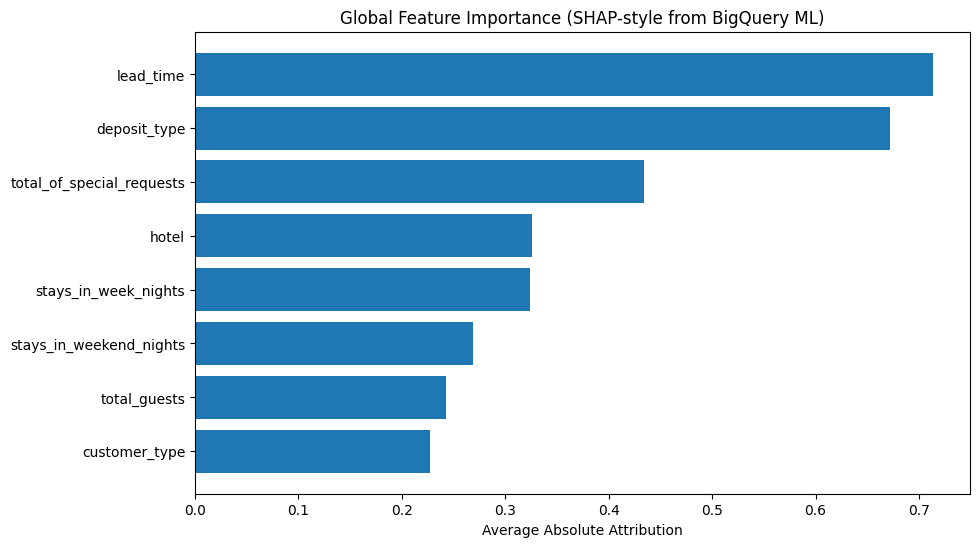

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(df_global_importance['feature'], df_global_importance['avg_influence'])
plt.gca().invert_yaxis()
plt.title("Global Feature Importance (SHAP-style from BigQuery ML)")
plt.xlabel("Average Absolute Attribution")
plt.show()


Make it Interactive

In [8]:
import plotly.express as px

# Sort so the bars look like your Matplotlib version (top at the top)
df_plot = df_global_importance.sort_values("avg_influence", ascending=True)

fig = px.bar(
    df_plot,
    x="avg_influence",
    y="feature",
    orientation="h",
    title="Global Feature Importance",
    labels={
        "avg_influence": "Average Absolute Attribution",
        "feature": "Feature"
    }
)

# Optional: make it a little cleaner
fig.update_layout(
    xaxis=dict(tickformat=".2f"),
    margin=dict(l=120, r=20, t=60, b=40)
)

fig.show()


Graph of Cancellation Rate by Deposit Type

In [11]:
query = """
SELECT
  deposit_type,
  AVG(is_canceled) AS cancel_rate
FROM `mgmt-467-94721.hotel_bookings.hotel_bookings_curated`
GROUP BY deposit_type
ORDER BY cancel_rate DESC
"""

df_cancel_rate = client.query(query).to_dataframe()

import plotly.express as px
fig = px.bar(
    df_cancel_rate,
    x="deposit_type",
    y="cancel_rate",
    text="cancel_rate",
    title="Cancellation Rate by Deposit Type (BigQuery)",
    labels={"cancel_rate": "Cancellation Rate"},
)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(yaxis=dict(tickformat=".0%"))
fig.show()


Graph of Cancellation Rate by Lead Time

In [12]:
from google.cloud import bigquery
import plotly.express as px
import pandas as pd

client = bigquery.Client(project="mgmt-467-94721")

# --- Query BigQuery ---
query = """
WITH binned AS (
  SELECT
    CASE
      WHEN lead_time BETWEEN 0 AND 7 THEN "0–7 days"
      WHEN lead_time BETWEEN 8 AND 14 THEN "8–14 days"
      WHEN lead_time BETWEEN 15 AND 30 THEN "15–30 days"
      WHEN lead_time BETWEEN 31 AND 60 THEN "31–60 days"
      WHEN lead_time BETWEEN 61 AND 90 THEN "61–90 days"
      WHEN lead_time BETWEEN 91 AND 180 THEN "91–180 days"
      WHEN lead_time > 180 THEN "180+ days"
    END AS lead_time_range,
    is_canceled
  FROM `mgmt-467-94721.hotel_bookings.training_data`
)

SELECT
  lead_time_range,
  AVG(is_canceled) AS cancellation_rate
FROM binned
GROUP BY lead_time_range
ORDER BY
  CASE lead_time_range
    WHEN "0–7 days" THEN 1
    WHEN "8–14 days" THEN 2
    WHEN "15–30 days" THEN 3
    WHEN "31–60 days" THEN 4
    WHEN "61–90 days" THEN 5
    WHEN "91–180 days" THEN 6
    WHEN "180+ days" THEN 7
  END;
"""

df_lead = client.query(query).to_dataframe()

# --- Plot ---
fig = px.line(
    df_lead,
    x="lead_time_range",
    y="cancellation_rate",
    markers=True,
    title="Cancellation Rate by Lead Time Range",
    labels={"lead_time_range": "Lead Time", "cancellation_rate": "Cancellation Rate"},
)

fig.update_traces(line_color="royalblue")
fig.update_yaxes(tickformat=".0%")
fig.update_layout(plot_bgcolor="rgba(240,240,255,0.4)")

fig.show()


Graph of Cancellation Rate by Temperature

In [13]:
from google.cloud import bigquery
import plotly.express as px
import pandas as pd

client = bigquery.Client(project="mgmt-467-94721")

query = """
WITH binned AS (
  SELECT
    CASE
      WHEN temperature_2m_mean < 0 THEN "< 0°C"
      WHEN temperature_2m_mean BETWEEN 0 AND 5 THEN "0–5°C"
      WHEN temperature_2m_mean BETWEEN 6 AND 10 THEN "6–10°C"
      WHEN temperature_2m_mean BETWEEN 11 AND 15 THEN "11–15°C"
      WHEN temperature_2m_mean BETWEEN 16 AND 20 THEN "16–20°C"
      WHEN temperature_2m_mean BETWEEN 21 AND 25 THEN "21–25°C"
      WHEN temperature_2m_mean BETWEEN 26 AND 30 THEN "26–30°C"
      WHEN temperature_2m_mean > 30 THEN "> 30°C"
    END AS temp_range,
    is_canceled
  FROM `mgmt-467-94721.hotel_bookings.weather_history`
  WHERE temperature_2m_mean IS NOT NULL
)

SELECT
  temp_range,
  AVG(is_canceled) AS cancellation_rate
FROM binned
GROUP BY temp_range
ORDER BY
  CASE temp_range
    WHEN "< 0°C" THEN 1
    WHEN "0–5°C" THEN 2
    WHEN "6–10°C" THEN 3
    WHEN "11–15°C" THEN 4
    WHEN "16–20°C" THEN 5
    WHEN "21–25°C" THEN 6
    WHEN "26–30°C" THEN 7
    WHEN "> 30°C" THEN 8
  END;
"""

df_temp = client.query(query).to_dataframe()

# --- Plot ---
fig = px.line(
    df_temp,
    x="temp_range",
    y="cancellation_rate",
    markers=True,
    title="Cancellation Rate by Temperature Range",
    labels={"temp_range": "Temperature Range", "cancellation_rate": "Cancellation Rate"},
)

fig.update_traces(line_color="crimson")
fig.update_yaxes(tickformat=".0%")
fig.update_layout(plot_bgcolor="rgba(240,240,255,0.4)")

fig.show()


Graph of Cancellation Rate by Wind Speed

In [19]:
from google.cloud import bigquery
import plotly.express as px
import pandas as pd

client = bigquery.Client(project="mgmt-467-94721")

query = """
WITH binned AS (
  SELECT
    CASE
      WHEN windspeed_10m_max < 2 THEN "< 2 m/s"
      WHEN windspeed_10m_max BETWEEN 2 AND 4 THEN "2–4 m/s"
      WHEN windspeed_10m_max BETWEEN 5 AND 7 THEN "5–7 m/s"
      WHEN windspeed_10m_max BETWEEN 8 AND 10 THEN "8–10 m/s"
      WHEN windspeed_10m_max BETWEEN 11 AND 13 THEN "11–13 m/s"
      WHEN windspeed_10m_max BETWEEN 14 AND 16 THEN "14–16 m/s"
      WHEN windspeed_10m_max > 16 THEN "> 16 m/s"
    END AS wind_range,
    is_canceled
  FROM `mgmt-467-94721.hotel_bookings.weather_history`
  WHERE windspeed_10m_max IS NOT NULL
)

SELECT
  wind_range,
  AVG(is_canceled) AS cancellation_rate
FROM binned
GROUP BY wind_range
ORDER BY
  CASE wind_range
    WHEN "< 2 m/s" THEN 1
    WHEN "2–4 m/s" THEN 2
    WHEN "5–7 m/s" THEN 3
    WHEN "8–10 m/s" THEN 4
    WHEN "11–13 m/s" THEN 5
    WHEN "14–16 m/s" THEN 6
    WHEN "> 16 m/s" THEN 7
  END;
"""

df_wind = client.query(query).to_dataframe()

# --- Plot ---
fig = px.line(
    df_wind,
    x="wind_range",
    y="cancellation_rate",
    markers=True,
    title="Cancellation Rate by Wind Speed (BigQuery ML Weather)",
    labels={
        "wind_range": "Wind Speed Range (m/s)",
        "cancellation_rate": "Cancellation Rate"
    },
)

fig.update_traces(line_color="royalblue")
fig.update_yaxes(tickformat=".0%")
fig.update_layout(plot_bgcolor="rgba(230,240,255,0.4)")

fig.show()


In [20]:
from google.cloud import bigquery
import plotly.express as px
import pandas as pd

client = bigquery.Client(project="mgmt-467-94721")

query = """
WITH binned AS (
  SELECT
    CASE
      WHEN windspeed_10m_max < 2 THEN "< 2 m/s"
      WHEN windspeed_10m_max >= 2  AND windspeed_10m_max < 5  THEN "2–4 m/s"
      WHEN windspeed_10m_max >= 5  AND windspeed_10m_max < 8  THEN "5–7 m/s"
      WHEN windspeed_10m_max >= 8  AND windspeed_10m_max < 11 THEN "8–10 m/s"
      WHEN windspeed_10m_max >= 11 AND windspeed_10m_max < 14 THEN "11–13 m/s"
      WHEN windspeed_10m_max >= 14 AND windspeed_10m_max <= 16 THEN "14–16 m/s"
      WHEN windspeed_10m_max > 16 THEN "> 16 m/s"
    END AS wind_range,
    is_canceled
  FROM `mgmt-467-94721.hotel_bookings.weather_history`
  WHERE windspeed_10m_max IS NOT NULL
)

SELECT
  wind_range,
  AVG(is_canceled) AS cancellation_rate
FROM binned
WHERE wind_range IS NOT NULL
GROUP BY wind_range
ORDER BY
  CASE wind_range
    WHEN "< 2 m/s" THEN 1
    WHEN "2–4 m/s" THEN 2
    WHEN "5–7 m/s" THEN 3
    WHEN "8–10 m/s" THEN 4
    WHEN "11–13 m/s" THEN 5
    WHEN "14–16 m/s" THEN 6
    WHEN "> 16 m/s" THEN 7
  END;
"""

df_wind = client.query(query).to_dataframe()

fig = px.line(
    df_wind,
    x="wind_range",
    y="cancellation_rate",
    markers=True,
    title="Cancellation Rate by Wind Speed (BigQuery ML Weather)",
    labels={"wind_range": "Wind Speed Range (m/s)", "cancellation_rate": "Cancellation Rate"},
)

fig.update_yaxes(tickformat=".0%")
fig.update_layout(plot_bgcolor="rgba(230,240,255,0.4)")
fig.show()


Graph of Cancellation Rate by Month

In [17]:
from google.cloud import bigquery
import plotly.express as px
import pandas as pd

client = bigquery.Client(project="mgmt-467-94721")

# Query cancellation rate by month
query = """
SELECT
  arrival_date_month AS month,
  AVG(is_canceled) AS cancellation_rate
FROM `mgmt-467-94721.hotel_bookings.weather_history`
GROUP BY month
ORDER BY
  CASE month
    WHEN 'January' THEN 1
    WHEN 'February' THEN 2
    WHEN 'March' THEN 3
    WHEN 'April' THEN 4
    WHEN 'May' THEN 5
    WHEN 'June' THEN 6
    WHEN 'July' THEN 7
    WHEN 'August' THEN 8
    WHEN 'September' THEN 9
    WHEN 'October' THEN 10
    WHEN 'November' THEN 11
    WHEN 'December' THEN 12
  END;
"""

df_month = client.query(query).to_dataframe()

# Plot with Plotly
fig = px.bar(
    df_month,
    x="month",
    y="cancellation_rate",
    title="Cancellation Rate by Month",
    labels={"cancellation_rate": "Cancellation Rate"},
    text=df_month["cancellation_rate"].round(2)
)

fig.update_traces(marker_color="cornflowerblue", textposition="outside")
fig.update_yaxes(tickformat=".0%")
fig.update_layout(
    plot_bgcolor="rgba(230,240,255,0.4)",
    xaxis_title="Month",
    yaxis_title="Cancellation Rate"
)

fig.show()



Graph of Cancellation Rate by Season

In [18]:
from google.cloud import bigquery
import plotly.express as px
import pandas as pd

client = bigquery.Client(project="mgmt-467-94721")

query = """
WITH season_map AS (
  SELECT
    CASE
      WHEN arrival_date_month IN ('December', 'January', 'February') THEN 'Winter'
      WHEN arrival_date_month IN ('March', 'April', 'May') THEN 'Spring'
      WHEN arrival_date_month IN ('June', 'July', 'August') THEN 'Summer'
      WHEN arrival_date_month IN ('September', 'October', 'November') THEN 'Fall'
    END AS season,
    is_canceled
  FROM `mgmt-467-94721.hotel_bookings.weather_history`
)

SELECT
  season,
  AVG(is_canceled) AS cancellation_rate
FROM season_map
GROUP BY season
ORDER BY
  CASE season
    WHEN 'Winter' THEN 1
    WHEN 'Spring' THEN 2
    WHEN 'Summer' THEN 3
    WHEN 'Fall' THEN 4
  END;
"""

df_season = client.query(query).to_dataframe()

# --- Plot ---
fig = px.bar(
    df_season,
    x="season",
    y="cancellation_rate",
    title="Cancellation Rate by Season",
    labels={"cancellation_rate": "Cancellation Rate"},
    text=df_season["cancellation_rate"].round(2)
)

fig.update_traces(marker_color="mediumseagreen", textposition="outside")
fig.update_yaxes(tickformat=".0%")
fig.update_layout(
    plot_bgcolor="rgba(230,255,240,0.4)",
    xaxis_title="Season",
    yaxis_title="Cancellation Rate"
)

fig.show()


Looker Studio Link

https://lookerstudio.google.com/reporting/4ae22beb-3898-47f3-b5f0-7b6097c70f82/page/yKjiF/edit?s=h5Sx9vzu3jM

Feature Importance by Hotel Type

In [13]:
from google.cloud import bigquery
client = bigquery.Client(project="mgmt-467-94721")

query = """
WITH explain AS (
  SELECT
    hotel,
    f.feature AS feature,
    f.attribution AS attribution
  FROM ML.EXPLAIN_PREDICT(
    MODEL `mgmt-467-94721.hotel_bookings.cancel_model_historical_weather`,
    (
      -- sample rows across both hotels
      SELECT *
      FROM `mgmt-467-94721.hotel_bookings.weather_history`
      LIMIT 2000
    ),
    STRUCT(1000 AS top_k_features)   -- include lots of features per row
  ),
  UNNEST(top_feature_attributions) AS f
)
SELECT
  hotel,
  feature,
  AVG(ABS(attribution)) AS avg_influence
FROM explain
GROUP BY hotel, feature
ORDER BY hotel, avg_influence DESC;
"""

df_importance_by_hotel = client.query(query).to_dataframe()
df_importance_by_hotel


,hotel,feature,avg_influence
0,City Hotel,deposit_type,0.684594
1,City Hotel,lead_time,0.659644
2,City Hotel,total_of_special_requests,0.337406
3,City Hotel,hotel,0.328606
4,City Hotel,stays_in_week_nights,0.177610
5,City Hotel,customer_type,0.169195
6,City Hotel,stays_in_weekend_nights,0.154827
7,City Hotel,total_guests,0.150290
8,City Hotel,arrival_date_week_number,0.027008
9,City Hotel,arrival_date_year,0.024514


Weather Features Only Importance

In [11]:
from google.cloud import bigquery
client = bigquery.Client(project="mgmt-467-94721")

# List your weather columns here
weather_features = [
    "temperature_2m_mean",
    "temperature_2m_max",
    "temperature_2m_min",
    "precipitation_sum",
    "windspeed_10m_max",
    "weathercode"
]

# Convert to a quoted list for SQL
weather_feature_list = ", ".join([f"'{f}'" for f in weather_features])

query = f"""
WITH explain AS (
  SELECT
    predicted_label,
    probability,
    f.feature AS feature,
    f.attribution AS attribution
  FROM ML.EXPLAIN_PREDICT(
    MODEL `mgmt-467-94721.hotel_bookings.cancel_model_historical_weather`,
    (
      SELECT *
      FROM `mgmt-467-94721.hotel_bookings.weather_history`
      LIMIT 1000  -- sample for global importance
    ),
    STRUCT(1000 AS top_k_features)
  ),
  UNNEST(top_feature_attributions) AS f
)

SELECT
  feature,
  AVG(ABS(attribution)) AS avg_influence
FROM explain
WHERE feature IN ({weather_feature_list})
GROUP BY feature
ORDER BY avg_influence DESC;
"""

df_weather_importance = client.query(query).to_dataframe()
df_weather_importance


,feature,avg_influence
0,windspeed_10m_max,0.022030
1,temperature_2m_mean,0.017935
2,weathercode,0.012633
3,temperature_2m_min,0.011267
4,temperature_2m_max,0.008332
5,precipitation_sum,0.001005


Weather Features Only Importance by Hotel Type

In [12]:
from google.cloud import bigquery
client = bigquery.Client(project="mgmt-467-94721")

weather_features = [
    "temperature_2m_mean",
    "temperature_2m_max",
    "temperature_2m_min",
    "precipitation_sum",
    "windspeed_10m_max",
    "weathercode"
]

weather_feature_list = ", ".join([f"'{f}'" for f in weather_features])

query = f"""
WITH explain AS (
  SELECT
    hotel,
    f.feature AS feature,
    f.attribution AS attribution
  FROM ML.EXPLAIN_PREDICT(
    MODEL `mgmt-467-94721.hotel_bookings.cancel_model_historical_weather`,
    (
      -- sample 2000 rows across both hotels
      SELECT *
      FROM `mgmt-467-94721.hotel_bookings.weather_history`
      LIMIT 2000
    ),
    STRUCT(1000 AS top_k_features)
  ),
  UNNEST(top_feature_attributions) AS f
)
SELECT
  hotel,
  feature,
  AVG(ABS(attribution)) AS avg_influence
FROM explain
WHERE feature IN ({weather_feature_list})
GROUP BY hotel, feature
ORDER BY hotel, avg_influence DESC;
"""

df_weather_by_hotel = client.query(query).to_dataframe()
df_weather_by_hotel


,hotel,feature,avg_influence
0,City Hotel,windspeed_10m_max,0.022810
1,City Hotel,temperature_2m_mean,0.020145
2,City Hotel,temperature_2m_min,0.013184
3,City Hotel,weathercode,0.012827
4,City Hotel,temperature_2m_max,0.009085
5,City Hotel,precipitation_sum,0.001008
6,Resort Hotel,windspeed_10m_max,0.028920
7,Resort Hotel,temperature_2m_mean,0.015731
8,Resort Hotel,weathercode,0.012956
9,Resort Hotel,temperature_2m_min,0.010108


### Reflection (DIVE Mindset)

### Discover
The initial question we had was whether weather meaningfully affects hotel booking cancellations beyond other drivers such as lead time and deposit type. Early exploratory analysis quickly showed that non-weather features—especially lead time and deposit type—were the strongest predictors of cancellation. However, initial visualizations of cancellation rate by season and wind speed suggested that cancellations were not evenly distributed throughout the year or across weather conditions, indicating that weather could still provide incremental explanatory power.

### Investigate
To investigate further, I experimented with alternative filters and queries that segmented the data by weather conditions rather than booking attributes. Specifically, binning temperature and wind speed revealed non-linear patterns that were not visible in raw averages. Filtering the analysis by hotel type (City vs Resort) changed the story. Weather variables had a stronger effect for Resort Hotels, where travel is more discretionary, than for City Hotels. This shift helped clarify that weather’s impact is context-dependent rather than universal.

### Validate
Because much of the SQL used in the analysis was AI-assisted, it was important to validate that results were not artifacts of incorrect queries. One key issue discovered was that missing or empty bins (certain wind speed ranges) caused misleading plots. This was validated by explicitly counting rows per bin and adjusting the SQL logic to remove gaps and null categories. Model-based validation was also performed by comparing a baseline BQML cancellation model to a weather-enhanced model and reviewing ML.EVALUATE metrics and ML.EXPLAIN_PREDICT outputs to confirm that weather features had consistent but smaller attribution values relative to core booking features.

### Extend
The results of this analysis would be immediately useful to a hotel revenue or operations manager. While lead time and deposit policies remain the primary levers to manage cancellation risk, weather-aware insights can support short-term operational decisions—such as staffing, overbooking buffers, or targeted customer communications during high-risk weather periods. In particular, resort properties could use forecasted weather to proactively manage cancellation exposure in the days leading up to arrival.


## Prompt Log

- You are part of a data analytics project using a hotel booking dataset. Suggest a simple but meaningful business question that can be answered by combining hotel booking data with a public weather API.

- You are building a batch-plus-streaming analytics pipeline. How should hotel booking data and weather data be structured and stored in BigQuery to support analysis and modeling?

- You are part of a data analytics project. Write BigQuery SQL to clean, curate, and prepare hotel booking data for downstream analysis and modeling.

- You are analyzing the relationship between weather and hotel booking cancellations. Generate BigQuery SQL to bin weather variables and calculate cancellation rates by weather condition.

- You are building a baseline machine learning model. Create BigQuery ML SQL for a cancellation prediction model using only booking-related features (no weather data).

- You are extending the baseline model. Create a BigQuery ML model that incorporates historical weather features to predict booking cancellations.

- You are evaluating two machine learning models. How can BigQuery ML.EVALUATE function be used to compare baseline and weather-enhanced models?

- You are interpreting a BigQuery ML model. Show how to use ML.EXPLAIN_PREDICT to identify which features most influence cancellation predictions.

- You are creating executive-level visualizations. Generate Python (Plotly) code to visualize cancellation rates by weather, seasonality, and booking attributes.

- You are debugging exploratory analysis results. Why might some weather bins be missing from cancellation-rate plots, and how can the SQL be corrected?

